# Warping playground
In Millican _et al._ (2025), Sec. III posits two techniques for handling underlying nonstationarity with a GP model: warping and a nonstationary kernel (NSK).
The purpose of this notebook is to develop techniques in those domains and experiment with them to improve the BUQEYE model and its limitations.

In [1]:
from cheftgp.eft import *
from cheftgp.gaussianprocess import *
from cheftgp.graphs import *
from cheftgp.scattering import *
from cheftgp.utils import *
from cheftgp.potentials import *
from scripts.generator_fns import *

import scipy
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit
from scipy.interpolate import interpn, griddata
import gsum
import functools 

from shapely.geometry import Polygon, Point

%matplotlib inline

In [2]:
def create_pairs(arr1, arr2):
    m, n = arr1.shape[0], arr2.shape[-1]
    pairs = np.empty((m, n, 2))
    for i in range(m):
        for j in range(n):
            pairs[i, j, 0] = arr1[i]  # Assign the first array to the first dimension of the pairs
            try:
                pairs[i, j, 1] = arr2[i, j]  # Assign the second array to the second dimension of the pairs
            except:
                pairs[i, j, 1] = arr2[j]
    return pairs

## Part 1: Nonstationarity in real data
This part of the notebook handles real data from any potential of the sixteen under test in Millican _et al._ (2025).

In [3]:
# warping function that operates on a 2D array
def warping_fn(pts_array):
    pts_array_shape = np.shape(pts_array)
    pts_array = np.reshape(pts_array, (np.prod(pts_array_shape[:-1]), ) + (pts_array_shape[-1], ))
    try:
        for pt_idx, pt in enumerate(pts_array):
            pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0],
                                             pts_array[pt_idx, 1]])
#         # SMS 550 MeV
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.28 / (136 * (pts_array[pt_idx, 0])**(-1.04)),])
        # SMS 500 MeV
        for pt_idx, pt in enumerate(pts_array):
            pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
                    pts_array[pt_idx, 1] * pts_array[pt_idx, 0]**(0.99) / 405,])
#         # SMS 450 MeV
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.30 / (38 * (pts_array[pt_idx, 0])**(-0.80)),])
#         # SCS 0.9 fm
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.30 / (120 * (pts_array[pt_idx, 0])**(-1.0)),])
#         # EMN 500 MeV
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.37 / (20 * (pts_array[pt_idx, 0])**(-0.66)),])
    except:
        pass

    pts_array = np.reshape(pts_array, pts_array_shape)

    return pts_array

# reverse-warping function
def reverse_warping_fn(pts_array):
    pts_array_shape = np.shape(pts_array)
    pts_array = np.reshape(pts_array, (np.prod(pts_array_shape[:-1]), ) + (pts_array_shape[-1], ))
    try:
        for pt_idx, pt in enumerate(pts_array):
            pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0],
                                             pts_array[pt_idx, 1]])
#         # SMS 550 MeV
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.28 / (136 * (pts_array[pt_idx, 0])**(-1.04)),])
#         # SMS 500 MeV
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] / 0.28 * (110 * (pts_array[pt_idx, 0])**(-0.99)),])
#         # SMS 450 MeV
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.30 / (38 * (pts_array[pt_idx, 0])**(-0.80)),])
#         # SCS 0.9 fm
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.30 / (120 * (pts_array[pt_idx, 0])**(-1.0)),])
#         # EMN 500 MeV
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.37 / (20 * (pts_array[pt_idx, 0])**(-0.66)),])
    except:
        pass

    pts_array = np.reshape(pts_array, pts_array_shape)

    return pts_array

# length-scale scaling function (for NSK approach)
def scaling_fn(X,
               ls_array = np.array([1]),
               exponent = 0, 
               magnitude = 1):
    X_shape = np.shape(X)
    X = np.reshape(X, (np.prod(X_shape[:-1]), ) + (X_shape[-1], ))
    ls = np.array([])
        
    for pt_idx, pt in enumerate(X):
        ls = np.append(ls, np.array([ls_array[0], ls_array[1]]))
#         ls = np.append(ls, np.array([ls_array[0], ls_array[1] * X[pt_idx, 0]**(-1. * exponent)
#                                      ]))
#         ls = np.append(ls, np.array([100, magnitude * X[pt_idx, 0]**(-1. * exponent)
#                                      ]))

    ls = np.reshape(ls, X_shape)

    return ls

scaling_fn_kwargs={"exponent" : 0.99, "magnitude" : 110}

# cbar^2 (i.e., variance) scaling function
def cbar_fn(X,
               cbar_array = np.array([1]),
               scaling = 1,
               offset = 0.5):
    X_shape = np.shape(X)
    X = np.reshape(X, (np.prod(X_shape[:-1]), ) + (X_shape[-1], ))
    cbar = np.array([])

    for pt_idx, pt in enumerate(X):
#         R = np.max(X[:, 0]) - np.min(X[:, 0])
        cbar = np.append(cbar, cbar_array)
#         cbar = np.append(cbar, np.array([(1 + (scaling / R * (pt[0] - offset * R)) ** (2)) ** (-0.5)
#                                          ]))
    cbar = np.reshape(cbar, X_shape[:-1])
    
    return cbar

cbar_fn_kwargs={"scaling" : 1.7,
                "offset" : 0.71}

In [4]:
# potential under test
ScaleScheme2D = RKE500MeV

# basic 2D input spaces
t_lab = ScaleScheme2D.get_data("t_lab")
degrees = ScaleScheme2D.get_data("degrees")

E_lab_val = None
angle_lab_val = None
E_angle_vals_pair = [E_lab_val, angle_lab_val]

if E_lab_val is not None:
    E_lab = np.array([E_lab_val])
else:
    E_lab = t_lab
print("E_lab = " + str(E_lab))

if angle_lab_val is not None:
    angle_lab = np.array([angle_lab_val])
else:
    angle_lab = degrees
print("angle_lab = " + str(angle_lab))

E_angle_pair = [E_lab, angle_lab]

# sets up options for observable(s)
SGTBunch = ObservableBunch(
            "SGT",
            ScaleScheme2D.get_data("SGT"),
            E_angle_vals_pair,
            "\sigma_{\mathrm{tot}}",
            "dimensionful",
            nn_interaction = "np",
            unit_string = "mb",
        )

DSGBunch = ObservableBunch(
            "DSG",
            ScaleScheme2D.get_data("DSG"),
            E_angle_vals_pair,
            "d \sigma / d \Omega",
            "dimensionful",
            nn_interaction = "np",
            unit_string="mb",
        )

DBunch = ObservableBunch(
            "D",
            ScaleScheme2D.get_data("D"),
            E_angle_vals_pair,
            "D",
            "dimensionless",
            nn_interaction = "np",
        )
AXXBunch = ObservableBunch(
            "AXX", 
            ScaleScheme2D.get_data("AXX"), 
            E_angle_vals_pair,
            "A_{xx}", 
            "dimensionless",
            nn_interaction = "np",
        )
AYYBunch = ObservableBunch(
            "AYY", 
            ScaleScheme2D.get_data("AYY"), 
            E_angle_vals_pair,
            "A_{yy}", 
            "dimensionless",
            nn_interaction = "np",
        )

ABunch = ObservableBunch(
            "A",
            ScaleScheme2D.get_data("A"),
            E_angle_vals_pair,
            "A",
            "dimensionless",
            nn_interaction = "np",
            constraint=[[0,], [0,], "angle"],
        )
AYBunch = ObservableBunch(
            "AY",
            ScaleScheme2D.get_data("PB"),
            E_angle_vals_pair,
            "A_{y}",
            "dimensionless",
            nn_interaction = "np",
            constraint=[[0, -1], [0, 0], "angle"],
        )

# chooses observable for test
Observable2D = DSGBunch

E_lab = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 24

In [5]:
# sets up options for scattering-angle (x_E) input space(s)
# ElabBunch = InputSpaceBunch(
#                     "Elab",
#                     Elab_fn,
#                     p_approx(
#                         "pprel",
#                         E_to_p(E_lab, interaction="np"),
#                         angle_lab,
#                     ),
#                     r"$E_{\mathrm{lab}}$ (MeV)",
#                     [r"$", Observable2D.title, r"(E_{\mathrm{lab}}, \theta= ", angle_lab_val, "^{\circ})$"],
#                 )

PrelBunch = InputSpaceBunch(
                    "prel",
                    E_to_p,
                    p_approx(
                        "pprel",
                        E_to_p(E_lab, interaction="np"),
                        angle_lab,
                    ),
                    r"$p_{\mathrm{rel}}$ (MeV)",
                    [r"$", Observable2D.title, r"(p_{\mathrm{rel}}, \theta= ", angle_lab_val, "^{\circ})$"],
                )

# sets up options for scattering-angle (x_theta) input space(s)
CosBunch = InputSpaceBunch(
                "cos",
                neg_cos,
                p_approx(
                    "pprel",
                    E_to_p(E_lab, interaction="np"),
                    angle_lab,
                ),
                r"$-\mathrm{cos}(\theta)$",
                [
                    r"$",
                    Observable2D.title,
                    r"(-\mathrm{cos}(\theta), E_{\mathrm{lab}}= ",
                    E_lab_val,
                    "\,\mathrm{MeV})$",
                ],
            )

# QcmBunch = InputSpaceBunch(
#                 "qcm",
#                 deg_to_qcm,
#                 p_approx(
#                     "pprel",
#                     E_to_p(E_lab, interaction="np"),
#                     angle_lab,
#                 ),
#                 r"$q_{\mathrm{cm}}$ (MeV)",
#                 [
#                     r"$",
#                     Observable2D.title,
#                     r"(q_{\mathrm{cm}}, E_{\mathrm{lab}}= ",
#                     E_lab_val,
#                     "\,\mathrm{MeV})$",
#                 ],
#             )

# Qcm2Bunch = InputSpaceBunch(
#                 "qcm2",
#                 deg_to_qcm2,
#                 p_approx(
#                     "pprel",
#                     E_to_p(E_lab, interaction="np"),
#                     angle_lab,
#                 ),
#                 r"$q_{\mathrm{cm}}^{2}$ (MeV$^{2}$)",
#                 [
#                     r"$",
#                     Observable2D.title,
#                     r"(q_{\mathrm{cm}}^{2}, E_{\mathrm{lab}}= ",
#                     E_lab_val,
#                     "\,\mathrm{MeV})$",
#                 ],
#             )

# creates 2D (x_E, x_theta) input space array
vsquantity_array = [PrelBunch,CosBunch]
for vsq in vsquantity_array:
    try:
        vsq.make_title()
    except:
        pass

In [6]:
# sets up the train/test split
# A few are given here as options, of which "nicegrid" is preferred.
TTS = TrainTestSplit("nicegrid", [5, 4], [2, 2], 
           xmin_train_factor = [0, 0], 
           xmax_train_factor = [1, 1])
# TTS = TrainTestSplit("experimentalgrid", [7, 7], [2, 2], 
#            xmin_train_factor = [0, 0], 
#            xmax_train_factor = [1, 1],
#            offset_train_min_factor = [0, 0.02], 
#            offset_test_min_factor = [0, 0.02], 
# #            offset_train_max_factor = [0, 0.02], 
# #            offset_test_max_factor = [0, 0.02]
#                     )
# TTS = TrainTestSplit("nolowpgrid", [3, 4], [2, 2], 
#            xmin_train_factor = [0, 0], 
#            xmax_train_factor = [1, 1],
#            offset_train_min_factor = [0.25, 0], 
#            offset_test_min_factor = [0.25, 0], 
#                     )

In [7]:
# sets up two-entry array of length scales
ls_array = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True), 
            LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)]

# calculates initial guesses for length scale(s)
for (ls, vsq) in zip(ls_array, vsquantity_array):
    ls.make_guess(
            vsq.input_space(
                **{
                    "deg_input": angle_lab,
                    "p_input": E_to_p(
                            E_lab, interaction="np"
                        ),
                    "E_lab": E_lab,
                    "interaction": "np",
                }
            )
        )
#     print(np.shape(vsq.input_space(
#                 **{
#                     "deg_input": angle_lab,
#                     "p_input": E_to_p(
#                             E_lab, interaction="np"
#                         ),
#                     "E_lab": E_lab,
#                     "interaction": "np",
#                 }
#             )))
#     print(vsq.input_space(
#                 **{
#                     "deg_input": angle_lab,
#                     "p_input": E_to_p(
#                             E_lab, interaction="np"
#                         ),
#                     "E_lab": E_lab,
#                     "interaction": "np",
#                 }
#             ))
#     print(ls.ls_guess)

# calculates (2D) dimensionless expansion parameter Q
ratio = Q_approx(
            p_approx("pprel", E_to_p(E_lab, "np"), angle_lab),
            "sum",
            Lambda_b=570,
            m_pi=138,
        ).T

# sets initial guesses for GP hyperparameters
GPHyper2D = GPHyperparameters(
            ls_array,
            center = 0,
            ratio = ratio,
            df=1,
            disp=0,
            scale=1,
            seed=None,
            sd=None,
        )

In [8]:
# sets information on orders
Orders2D = OrderInfo(
            ScaleScheme2D.orders_full,
            [0] + [],
            ScaleScheme2D.colors,
            ScaleScheme2D.light_colors,
            orders_names_dict=None,
            orders_labels_dict=None,
        )

In [9]:
# sets filenaming function
FileName2D = FileNaming(
                "sum",
                "pprel",
                filename_addendum="",
            )

In [10]:
# formally establishes the quantities in the input space
x_quantity = [["energy", E_lab, t_lab, "MeV"], ["angle", angle_lab, degrees, "degrees"]]

In [11]:
# creates GSUM objects necessary to generate statistical diagnostics
My2DPlot = GSUMDiagnostics(
                    schemescale = ScaleScheme2D,
                    observable = Observable2D, 
                    inputspace = vsquantity_array, 
                    traintestsplit = TTS,
                    gphyperparameters = GPHyper2D, 
                    orderinfo = Orders2D, 
                    filenaming = FileName2D,
                    whether_stationary = False,
                    x_quantity=x_quantity, 
                    warping_fn = warping_fn,
                    warping_fn_kwargs = {},
                    length_scale_list=
                        [NSKernelParam(50, [1, 200]),
#                         NSKernelParam(100, [1, 1000])],
                        NSKernelParam(0.01, [0.001, 20])],
                    length_scale_fixed=False,
                    cbar_list=[NSKernelParam(1.0, [0.1, 10])],
                    cbar_fixed=True,
                    scaling_fn = scaling_fn,
                    scaling_fn_kwargs = scaling_fn_kwargs,
                    cbar_fn = cbar_fn,
                    cbar_fn_kwargs = cbar_fn_kwargs,
)

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no

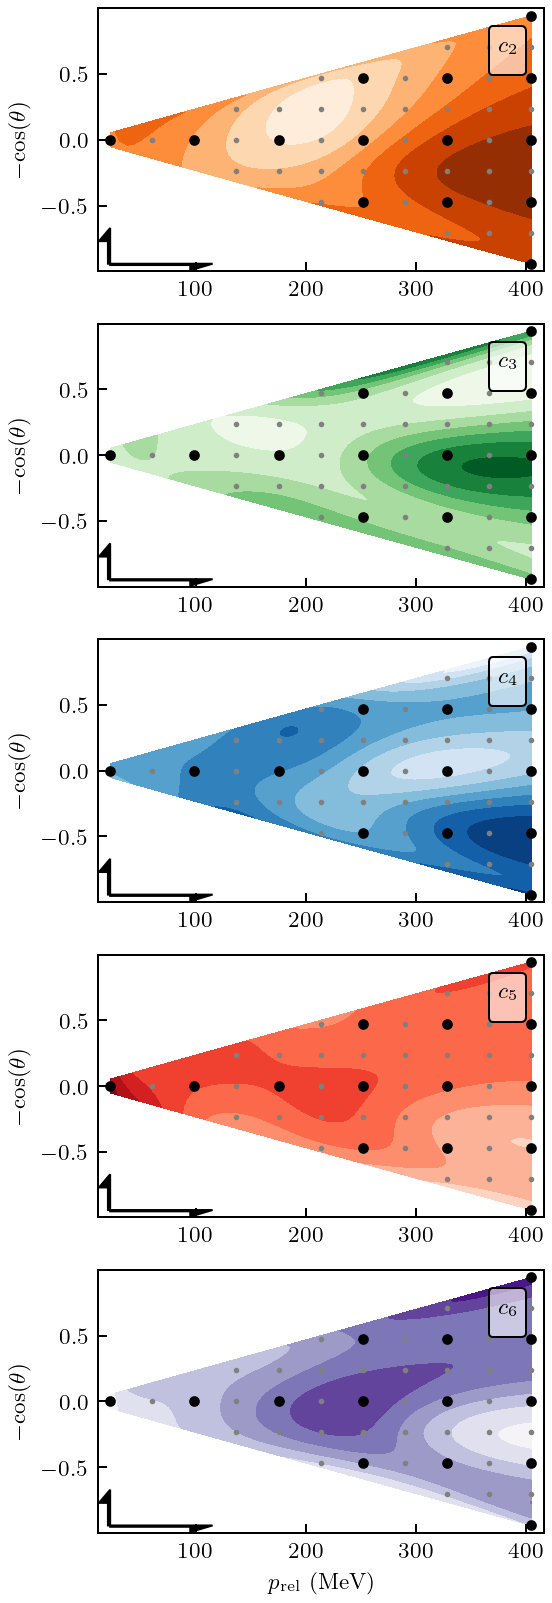

In [12]:
# plots 2D coefficients
My2DPlot.plot_coefficients(whether_save=False)

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


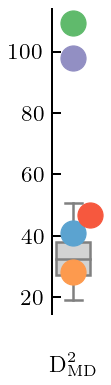

In [13]:
# plots Mahalanobis distance (squared)
My2DPlot.plot_md(whether_save=False)

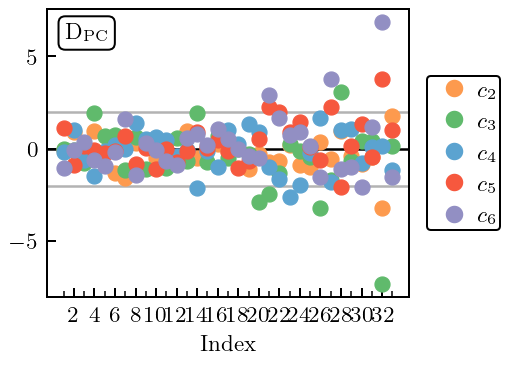

In [14]:
# plots pivoted Cholesky decomposition
My2DPlot.plot_pc(whether_save=False)

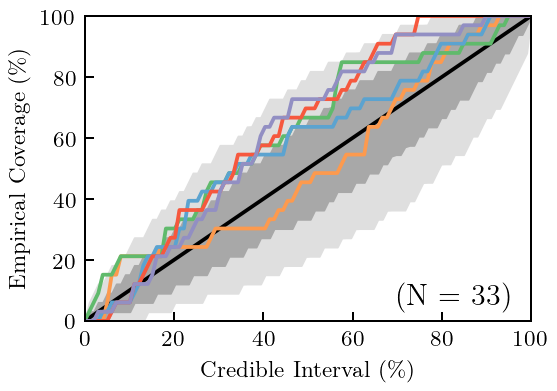

In [15]:
# plots credible intervals (a/k/a weather plot)
My2DPlot.plot_credible_intervals(whether_save=False)

## Part 2: Nonstationarity in toy data
This section of the notebook deals with exploring nonstationarity in toy (i.e., synthetic) data.

In [16]:
# length-scale scaling function for synthetic data
def scaling_fn_toy(X,
               ls_array = np.array([1]),
               exponent = 0):
    X_shape = np.shape(X)
    X = np.reshape(X, (np.prod(X_shape[:-1]), ) + (X_shape[-1], ))
    ls = np.array([])
    
    for pt_idx, pt in enumerate(X):
#         ls = np.append(ls, ls_array)
        ls = np.append(ls, np.array([ls_array[0], ls_array[1] * X[pt_idx, 0]**(-1. * exponent)
                                     ]))

    ls = np.reshape(ls, X_shape)

    return ls

scaling_fn_toy_kwargs={}

# cbar^2 (i.e., variance) scaling function for synthetic data
def cbar_fn_toy(X,
               cbar_array = np.array([1]),
               scaling = 1,
               offset = 0.5):
    X_shape = np.shape(X)
    X = np.reshape(X, (np.prod(X_shape[:-1]), ) + (X_shape[-1], ))
    cbar = np.array([])

    for pt_idx, pt in enumerate(X):
#         cbar = np.append(cbar, cbar_array)
        R = np.max(X[:, 0]) - np.min(X[:, 0])
        cbar = np.append(cbar, np.array([(1 + (scaling / R * (pt[0] - offset * R)) ** (2)) ** (-0.5)
                                         ]))
    cbar = np.reshape(cbar, X_shape[:-1])

    return cbar

cbar_fn_toy_kwargs={"scaling" : 4.8,
                "offset" : 0.63}

In [17]:
n_orders = 6    # Here we examine the case where we have info on some numer of non-trivial orders
final_order = 20  # We are going to treat some high order result as the final, converged answer
orders_array = np.arange(0, n_orders, 1, dtype = int)
orders_all_array = np.arange(0, final_order + 1, 1, dtype = int)

t_lab = np.linspace(1, 351, 51)
degrees = np.linspace(1, 179, 49)

E_lab = t_lab
angle_lab = degrees
E_angle_pair = [E_lab, angle_lab]

# The true values of the hyperparameters for generating the EFT coefficients
ls_E = 100
ls_deg = 45
ls_deg_mag = 900
ls_deg_exp = 0.5
scaling_fn_toy_kwargs.update({"exponent" : ls_deg_exp})
sd_gp = 1.0
sd_fixed = None
center = 0
ref = 1
nugget = 1e-10
df = 3
disp = 0
scale = 1.0
seed = 118

# sets 2D momentum mesh
p_toy = p_approx("pprel", E_to_p(t_lab, interaction = "np"), degrees).T
print(np.shape(p_toy))
print(p_toy)
Q_param_toy = "sum"
p_param_toy = "pprel"
mpi_toy = 96
Lambda_b_toy = 431
# if Q is constant, use next line
# ratio = 0.3
# if Q is not constant, use next line
Q_toy = Q_approx(p_toy, "sum", Lambda_b = Lambda_b_toy, m_pi = mpi_toy,
             single_expansion=False)

# sets kernels
# kernel_toy = RBF(length_scale=(ls_E, ls_deg),
#                length_scale_bounds=((ls_E / 4, ls_E * 4),
#                                     (ls_deg / 4, ls_deg * 4))) + \
#            WhiteKernel(1e-6, noise_level_bounds='fixed')
kernel_toy = NSRBF(length_scale=(ls_E, ls_deg_mag),
               length_scale_bounds=((ls_E / 4, ls_E * 4),
                                    (ls_deg_mag / 4, ls_deg_mag * 4)), 
                  length_scale_fixed = True, 
                  length_scale_fn=scaling_fn_toy,
                length_scale_fn_kwargs=scaling_fn_toy_kwargs,

                cbar=(1),
                cbar_bounds=((0.01, 10)),
                cbar_fixed=True,
                cbar_fn=cbar_fn_toy,
                cbar_fn_kwargs=cbar_fn_toy_kwargs,) + \
           NSWhiteKernel(1e-6, noise_level_bounds='fixed')

# creates Gaussian processes
gp_toy = gm.ConjugateGaussianProcess(kernel = kernel_toy, 
                        center = center, df = df, disp = disp, 
                        scale = scale, nugget = 1e-10, sd = sd_fixed)
# generates coefficients randomly up to final_order
coeffs_toy = np.swapaxes(np.reshape(- gp_toy.sample_y(np.array(list(itertools.product(t_lab, degrees))), 
                         n_samples = n_orders, 
                         random_state = seed), (len(t_lab), len(degrees), n_orders)).T, 1, 2)

(51, 49)
[[ 21.65954334  21.65954334  21.65954334 ...  21.65954334  21.65954334
   21.65954334]
 [ 61.26243994  61.26243994  61.26243994 ...  61.26243994  61.26243994
   61.26243994]
 [ 83.88705078  83.88705078  83.88705078 ...  83.88705078  83.88705078
   83.88705078]
 ...
 [397.61637528 397.61637528 397.61637528 ... 397.61637528 397.61637528
  397.61637528]
 [401.72469809 401.72469809 401.72469809 ... 401.72469809 401.72469809
  401.72469809]
 [405.79142946 405.79142946 405.79142946 ... 405.79142946 405.79142946
  405.79142946]]


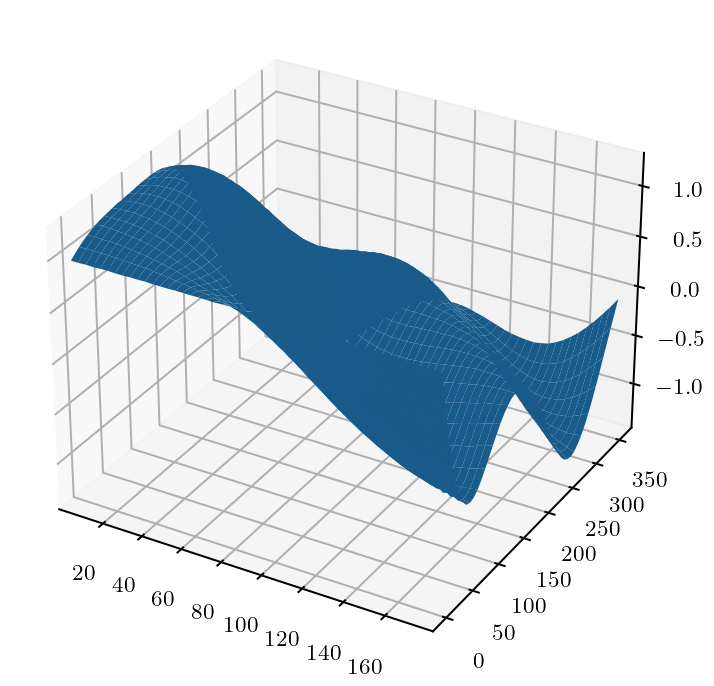

In [18]:
# plots coefficients at an order
fig = plt.figure()
ax = plt.axes(projection="3d")
(XA, XB) = np.meshgrid(degrees, t_lab)
ax.plot_surface(XA, XB, coeffs_toy[0, :, :])

In [19]:
# generates data using coefficients and other EFT parameters (e.g., dimensionless expansion parameter)
data_toy = gm.partials(
    coeffs = np.reshape(coeffs_toy, (n_orders, len(t_lab) * len(degrees))).T, 
    # if Q is not constant, use next line
    ratio = np.reshape(Q_toy, (len(t_lab) * len(degrees))), 
    # if Q is constant, use next line
#     ratio = ratio,
    ref = ref, 
    orders = orders_array)

data_toy = np.reshape(data_toy.T, (n_orders, len(t_lab), len(degrees)))

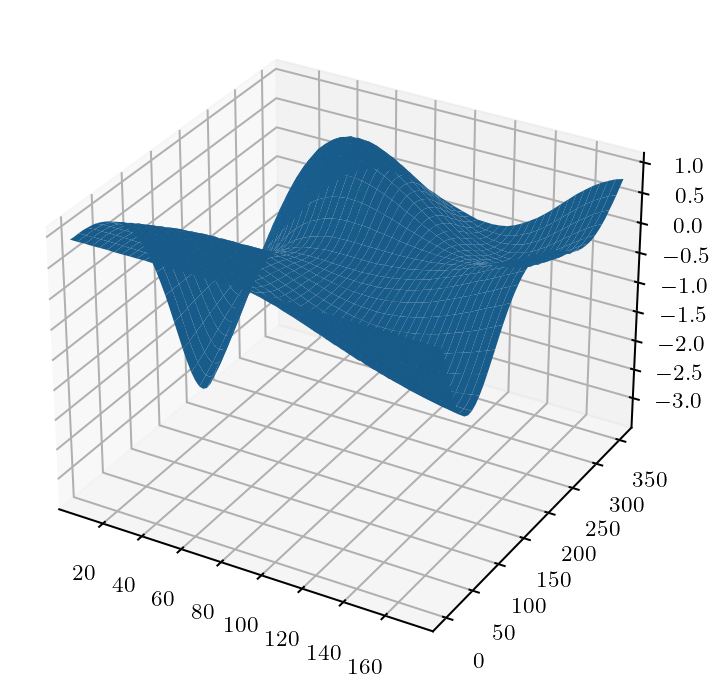

In [20]:
# plots data at an order
fig = plt.figure()
ax = plt.axes(projection="3d")
(XA, XB) = np.meshgrid(degrees, t_lab)
ax.plot_surface(XA, XB, data_toy[3, :, :])

In [21]:
# sets the potential under test
ScaleSchemeToy = ScaleSchemeBunch(
    "",
    np.array([0, 1, 2, 3, 4, 5,]),
    ["Oranges", "Greens", "Blues", "Reds", "Purples"],
    "Toy",
    "Data",
)

# sets the observable under test
OBSToy = ObservableBunch(
            "OBS",
            data_toy,
            E_angle_pair,
            "Obs.",
            "dimensionless",
            nn_interaction = "np",
            unit_string="",
        )
ObservableToy = OBSToy

In [22]:
# sets the "x_E" input space
ElabBunch = InputSpaceBunch(
                    "Elab",
                    Elab_fn,
                    p_approx(
                        "Qofprel",
                        E_to_p(t_lab, interaction="np"),
                        degrees,
                    ),
                    r"$E_{\mathrm{lab}}$ (MeV)",
                    [r"$", ObservableToy.title, r"(E_{\mathrm{lab}}, \theta= ", 0, "^{\circ})$"],
                )

# sets the "x_theta" input space
DegBunch = InputSpaceBunch(
                    "deg",
                    deg_fn,
                    p_approx(
                        "pprel",
                        E_to_p(t_lab, interaction="np"),
                        degrees,
                    ),
                    r"$\theta$ (deg)",
                    [
                        r"$",
                        ObservableToy.title,
                        r"(\theta, E_{\mathrm{lab}}= ",
                        0,
                        "\,\mathrm{MeV})$",
                    ],
                )

# sets the full 2D input space
vsquantity_array_toy = [ElabBunch, DegBunch]
for vsq in vsquantity_array_toy:
    try:
        vsq.make_title()
    except:
        pass

In [23]:
# sets (x_E, x_theta) length scale objects for fitting
ls_array_toy = [LengthScale("1/16-1_fitted", 2/7, 0.25, 4, whether_fit=True), 
            LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)]

# makes initial guesses for the length scales
for (ls, vsq) in zip(ls_array_toy, vsquantity_array_toy):
    ls.make_guess(
            vsq.input_space(
                **{
                    "deg_input": angle_lab,
                    "p_input": E_to_p(
                            E_lab, interaction="np"
                        ),
                    "E_lab": E_lab,
                    "interaction": "np",
                }
            )
        )
#     print(np.shape(vsq.input_space(
#                 **{
#                     "deg_input": angle_lab,
#                     "p_input": E_to_p(
#                             E_lab, interaction="np"
#                         ),
#                     "E_lab": E_lab,
#                     "interaction": "np",
#                 }
#             )))
#     print(vsq.input_space(
#                 **{
#                     "deg_input": angle_lab,
#                     "p_input": E_to_p(
#                             E_lab, interaction="np"
#                         ),
#                     "E_lab": E_lab,
#                     "interaction": "np",
#                 }
#             ))
#     print(ls.ls_guess)

# sets (2D) dimensionless expansion parameter Q
ratio_toy = Q_approx(
            p_approx("pprel", E_to_p(E_lab, "np"), angle_lab),
            "sum",
            Lambda_b=431,
            m_pi=96,
        ).T

# sets initial guesses for GP hyperparameters
GPHyperToy = GPHyperparameters(
            ls_array_toy,
            center = 0,
            ratio = ratio_toy,
            df=1,
            disp=0,
            scale=1,
            seed=None,
            sd=None,
        )

In [24]:
# information on orders
OrdersToy = OrderInfo(
            ScaleSchemeToy.orders_full,
            [0] + [],
            ScaleSchemeToy.colors,
            ScaleSchemeToy.light_colors,
            orders_names_dict=None,
            orders_labels_dict=None,
        )

In [25]:
# sets file-naming convention
FileNameToy = FileNaming(
                "sum",
                "pprel",
                filename_addendum="",
            )

In [26]:
# sets base (x_E, x_theta) input spaces
x_quantity = [["energy", E_lab, t_lab, "MeV"], ["angle", angle_lab, degrees, "degrees"]]

In [27]:
# sets train/test split
TTS = TrainTestSplit("nicegrid", [4, 4], [3, 3], 
           xmin_train_factor = [0, 0], 
           xmax_train_factor = [1, 1])

In [28]:
# creates GSUM objects necessary to generate statistical diagnostics
Toy2D = GSUMDiagnostics(
                    schemescale = ScaleSchemeToy,
                    observable = ObservableToy, 
                    inputspace = vsquantity_array_toy, 
                    traintestsplit = TTS,
                    gphyperparameters = GPHyperToy, 
                    orderinfo = OrdersToy, 
                    filenaming = FileNameToy,
                    x_quantity=x_quantity,
                    whether_stationary = False,
                    warping_fn = None,
                    warping_fn_kwargs = {},
                    length_scale_list=[NSKernelParam(60, [10, 200]),
                        NSKernelParam(1000, [100, 10000])],
#                         NSKernelParam(50, [5, 200])],
                    length_scale_fixed=False,
                    cbar_list=[NSKernelParam(1.0, [0.1, 10])],
                    cbar_fixed=True,
                    scaling_fn = scaling_fn_toy,
                    scaling_fn_kwargs = scaling_fn_toy_kwargs,
                    cbar_fn = cbar_fn_toy,
                    cbar_fn_kwargs = cbar_fn_toy_kwargs,
)

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-17.58479648,  36.5524559 ]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 42, 'nit': 2, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.24371204, 40.75944431]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 38, 'nit': 1, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-25.38114168,  55.73132694]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 81, 'nit': 7, 'warnflag': 2}
 

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-18.06943721,  62.0526888 ]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 2, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([20.6823754 , 48.86563357]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 3, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  21.88427592, -763.37680198]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 3, 'warnflag': 2}

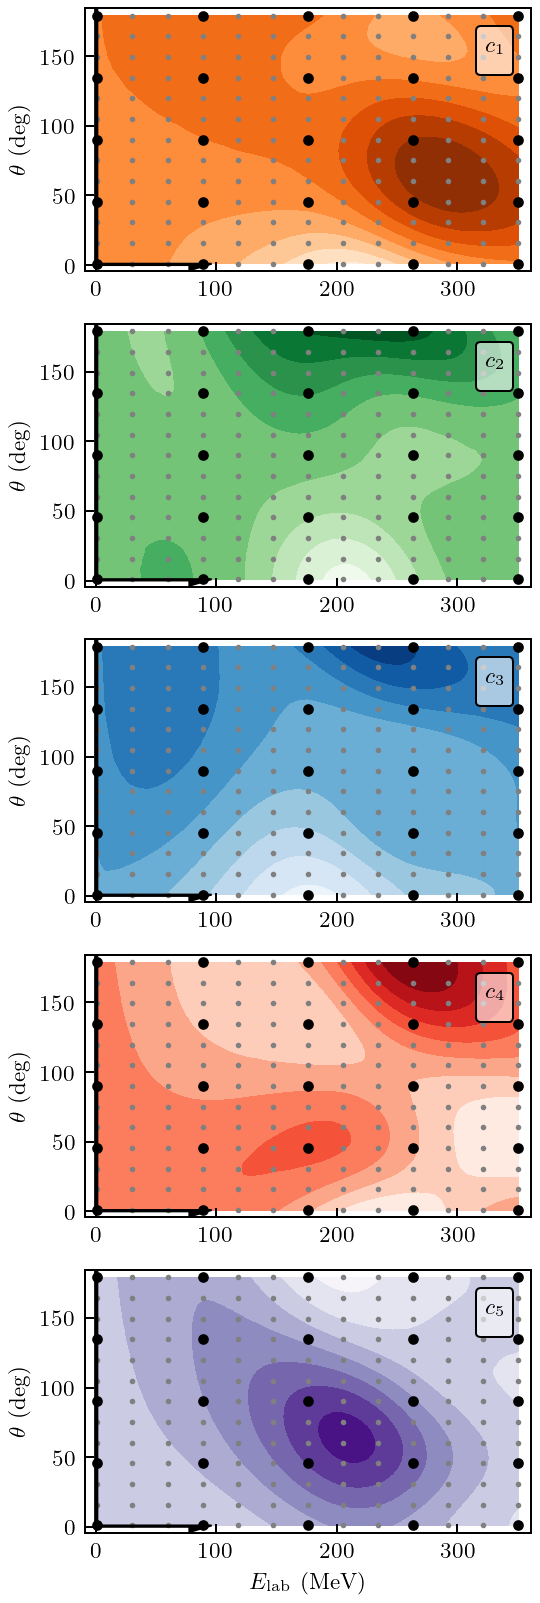

In [29]:
# plots 2D coefficients
Toy2D.plot_coefficients(whether_save=False)

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


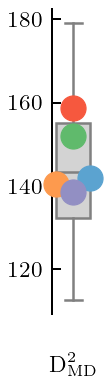

In [30]:
# plots Mahalanobis distance (squared)
Toy2D.plot_md(whether_save=False)

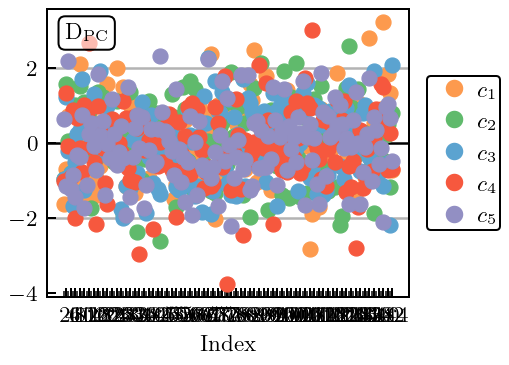

In [31]:
# plots pivoted Cholesky decomposition
Toy2D.plot_pc(whether_save=False)

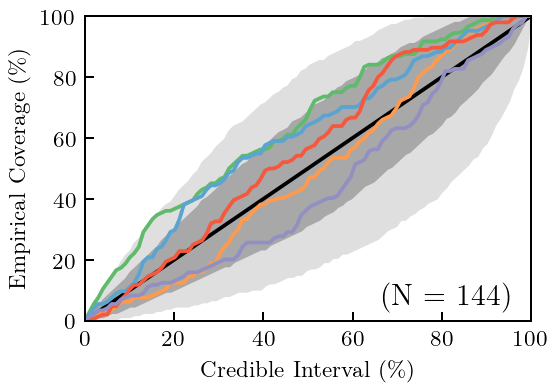

In [32]:
# plots credible intervals (a/k/a weather plots)
Toy2D.plot_credible_intervals(whether_save=False)